# Introducción a `PYMC`

La *estadística bayesiana moderna* ha cambiado significativamente en las últimas décadas. Se apoya, por supuesto, en el *teorema de Bayes*

$$
p(\theta | Y) = \frac {p(Y|\theta) \times p(\theta)}
{\int{p(Y|\theta) p(\theta) d\theta}}
$$

La mayor dificultad está en que la distribución a posteriori puede no tener expresión analítica salvo que forcemos al denominador del miembro derecho (la probabilidad marginal de la data) a ser resoluble analíticamente.
Por esta razón, muchas veces nos apoyamos en la expresión

$$
p(\theta | Y) \propto \mathcal{L}(y;\theta) \times p(\theta)
$$

Y recurrimos (en la mayoría de los casos) a métodos computacionales.
En las clases anteriores vimos 3 formas de obtener la distribución a posteriori:

1. Priors conjugados
2. Aroximación cuadrática
3. Grid Sampling

Hoy vamos a ver la cuarta:
## *Montecarlo basado en Cadenas de Markov* (MCMC).  

MCMC es una familia de algoritmos para estimar una distribución target desconocida y generalmente compleja, como una posterior. No trata de calcular o aproximar la posterior directamente sino que **va tomando muestras** de la posterior a partir de un proceso estocástico.  Las muestras de la posterior se generan aceptando o rechazando muestras de una distribución distinta (llamada la distribución propuesta), dado un conjunto de reglas para aceptar o rechazar las muestras).

Uno termina con una colección de tamaño arbitrario de valores de  y las frecuencias de esos valores corresponden a la probabilidad posterior (o sea, el histograma de estas muestras vendría a mostrar el estimador de la posterior).


Una vez obtenidas las muestras de la posterior, uno puede manipularlas al igual que cualquier otro sampleo visto hasta ahora (grid sampling por ejemplo):
* inferencias sobre los parámetros del modelo como definir intervalos de confianza,
* estimadores puntuales,
* etc.

#### Distribución conjunta y marginal
Para modelos con varios parámetros, uno obtiene muestras de la posterior conjunta, para obtener la posterior de un parámetro en en particular, debemos simplemente marginalizar (sumar sobre todos los demás parámetros) para obtener las distribuciones marginales de cada parámetro

#### Método
No requiere maximizar nada ni usar aproximaciones cuadráticas ni asumir que la posterior tenga forma gaussiana (o cualquier otra en particular).

**Pros:**  
> No se basa en aproximación cuadrática, no necesita asumir que la posterior tiene forma gaussiana ni ninguna otra forma.  
Por ello, es capaz de trabajar con modelos más complejos, como GLMs o modelos jerárquicos (multinivel).

**Contra:**   
> Puede tardar mucho más tiempo en completar la estimación de la posterior y suele necesitar más trabajo para especificar el modelo.

###  Idea general de MCMC:
1. Se construye una cadena de Markov empezando en algún punto del espacio de parámetros  
1. Se agregan nuevos links a la cadena a partir de un algoritmo estocástico  
1. Después de una cantidad de pasos, los eslabones de la cadena serán samples de la posterior.  

Los distintos algoritmos de MCMC se diferencian entre sí en la manera en la que se producen los nuevos links. Nosotros vamos a trabajar con `PyMC3`, que es un paquete de python de programación probabilística, que usa el método *Hamiltonian Monte Carlo* (HMC) con una variante llamada *No-U-Turn Sampler* (NUTS) (para más detalles sobre HMC o NUTS ver el capítulo IX del statistical rethinking).








## Metropolis-Hastings

Para conseguir muestras de la posterior $p(\theta|Y)$ se propone:


1. Inicializar $\theta$ en $\theta_0$

2. Usar una distribución propuesta $q(\theta_j | \theta_i)$ para proponer un valor de $\theta_j$ a partir de $\theta_i$ de la que sea sencillo samplear.

3. Usar el criterio de aceptación *Metrópolis*  

$$
p_a(\theta_j | \theta_i) = \min \left( 1 , \frac{p(\theta_j|Y)} { p(\theta_i|Y)}  \frac{q(\theta_j|\theta_j)} { q(\theta_j|\theta_i)} \right)
$$


4. Aceptar el candidato $\Leftrightarrow  p_a > R$ con $R\sim \mathcal{U}(0,1)$

5. Iterar los pasos 2-4 hasta que haya una muestra lo suficientemente grande.


### Ejemplo
Para ilustrar el algoritmo vamos a usar el ejemplo más frecuente en estadística bayesiana:


1. Tenemos un prior para $\theta$:
$$\theta \sim Beta(\alpha, \beta)$$  

2. Un modelo para los datos observados:
$$Y \sim Bernoulli(p=\theta)$$

3. Y queremos obtener la distribución posterior de $\theta$



In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


# Conseguir samples de Y
true_theta = .7
n = 20
Y = stats.bernoulli(true_theta).rvs(n)

In [8]:
# Implementar Metropolis-Hastings a mano (solo ejemplo, ya vamos a usar PyMC para que implemente las cadenas de markov por nosotros)

# Función auxiliar. Calcular la posterior sin normalizar
def unnorm_posterior(θ, Y, α=1, β=1):

  if θ < 0 or θ > 1:
    return - np.inf

  prior = stats.beta(α, β).pdf(θ)
  likelihood  = stats.bernoulli(θ).pmf(Y).prod()
  unnorm_posterior = likelihood * prior
  return unnorm_posterior


# Inicializar
reps = 10_000 # Cantidad de repeticiones
candidate_sd = .05 # STD de la distribución candidata
α = β =  1 # Parámetros del prior
θ = .5  # Inicializar theta
trace = {"θ":np.zeros(reps)} # Dict para guardar resultados
p1 = unnorm_posterior(θ, Y, α, β) # Inicializar posterior



# Implementar el algoritmo propiamente dicho
for i in range(reps):
  θ_candidate = stats.norm(θ, candidate_sd).rvs() # Samplear de q | simétrica
  p2 = unnorm_posterior(θ_candidate, Y, α, β) # Numerador
  pa = min(1, p2 / p1) # probabilidad de aceptar el candidato

  if pa > stats.uniform().rvs():
    θ = θ_candidate # Aceptarlo
    p1 = p2 # Actualizar denominador

  trace["θ"][i] = θ # Puede o no ser un nuevo valor

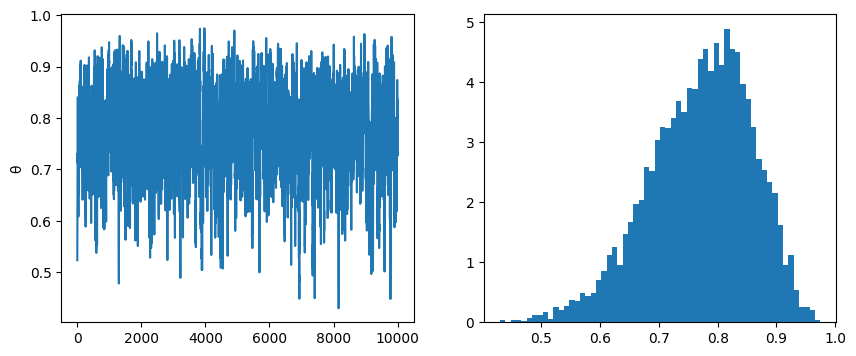

In [9]:
# Visualizar Cadena e Histograma

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(trace['θ'])
axs[0].set_ylabel('θ')

axs[1].hist(trace['θ'], density=True, bins=60)

plt.show()

In [10]:
import arviz as az

az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
θ,0.77,0.09,0.61,0.93


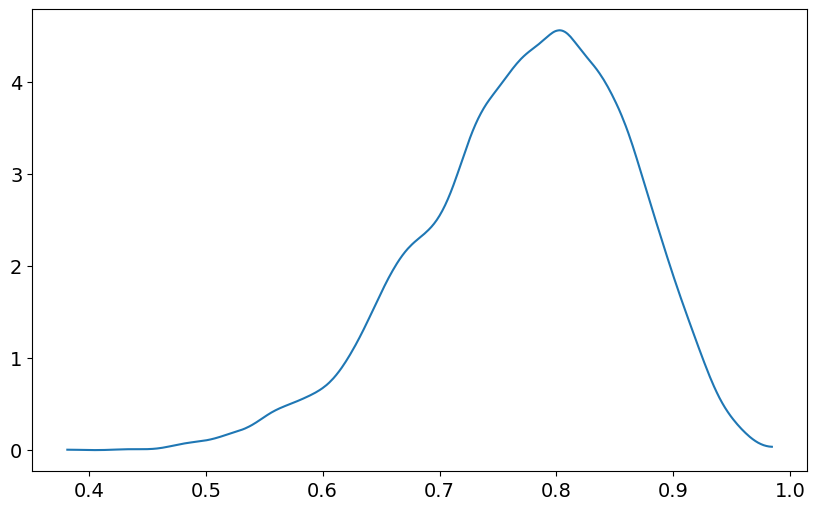

In [5]:
fig, ax = plt.subplots(figsize = (10,6))
az.plot_dist(trace['θ'], ax=ax)
plt.show()

# PyMC

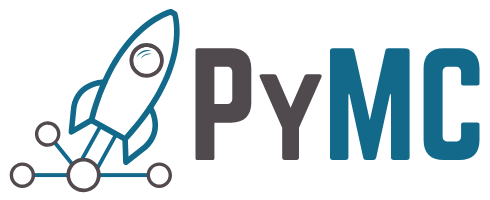


En las últimas décadas se incrementó muchísimo la complejidad de los modelos que podemos construir. Al mismo tiempo, y las barreras matemáticas y computacionales necesarias para utilizar los modeos disminuyeron significativamente. Ésto se debe, en gran parte, a la disponiblidad de *librerías de programación probabilísticas* (PPL) como `PyMC` (y *TensorFlow*, en `Python`; pero hay obviamente opciones  en otros lenguajes de programación como `R, Julia` y `STAN`).

Antes de ver cómo repetir el mismo ejercicio que antes, pero en `PyMC`, vamos a introducirnos suavemente en la PPL.


## Tomar muestrar de una variable aleatoria

$$
z \sim \mathcal{N}(10, 2^2)
$$

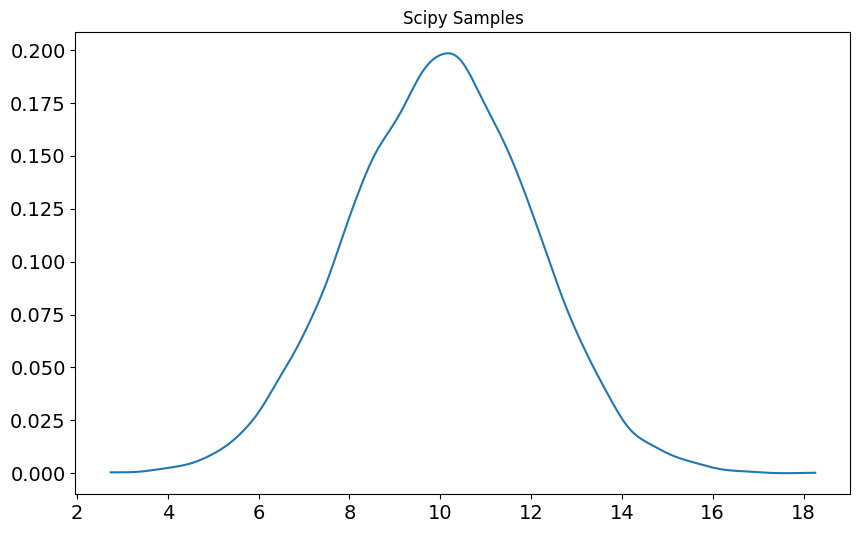

In [12]:
# Ya sabemos obtener samples de una distribución usando (por ejemplo) scipy

# Samplear
scipy_samples = stats.norm(loc=10, scale=2).rvs(10_000)

# Plotear
fig, ax = plt.subplots(figsize = (10,6))

az.plot_dist(scipy_samples)

plt.title('Scipy Samples')
plt.show()

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


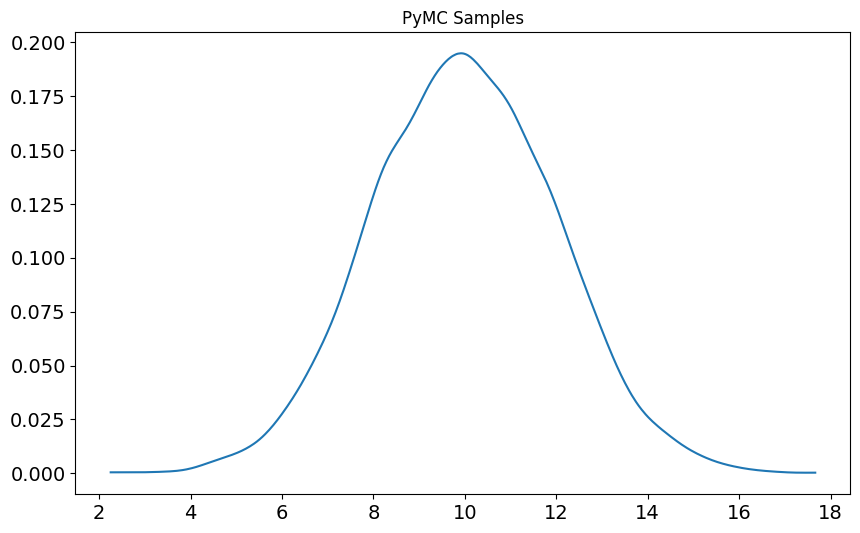

In [14]:
# Vamos a ver cómo obtener lo mismo en PyMC
import pymc as pm


# Crear un modelo con context manager
with pm.Model() as model:
  x = pm.Normal("x", mu=10, sigma=2) # Definir la V.A. X ~ N (10, 2**2)

  # Tomar la muestra
  pymc_samples = pm.draw(x, 10_000)



# Plotear con Arviz
fig, ax = plt.subplots(figsize = (10,6))
az.plot_dist(pymc_samples)
plt.title('PyMC Samples')
plt.show()

# Inferencia bayesiana


Ahora si, vamos a aprovechar para hacer el mismo ejercicio que antes.

Supongamos que tenemos los priors

$$\theta \sim Beta(\alpha, \beta)$$  
$$Y \sim Bernoulli(p=\theta)$$

Y que queremos obtener la posterior $\theta | Y$ tras observar $Y$


In [9]:
Y

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1],
      dtype=int64)

In [15]:
# Declarar el modelo
with pm.Model() as model:

    # Especificar el prior para θ
    θ = pm.Beta("θ", alpha=1, beta=1)

    # Especificar la likelihood, y condicionarla sobre los datos observados Y
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)

# Representar el modelo
model

In [19]:
# # Representación gráfica con graphviz
# pm.model_to_graphviz(model)

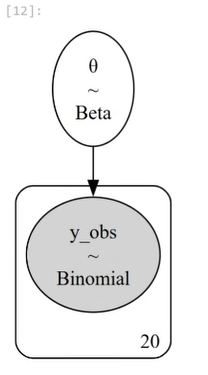

In [20]:
# Lo único que necesitamos ahora para hacer inferencia es tomar muestras de la posterior
with model:
    idata = pm.sample(draws=10_000)


# with model:
#     idata = pm.sample(draws=10_000, chains = n) #el libro recomienda n=1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.


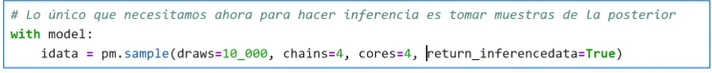

In [21]:
#idata.posterior['θ'].values #me da para el histograma

idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

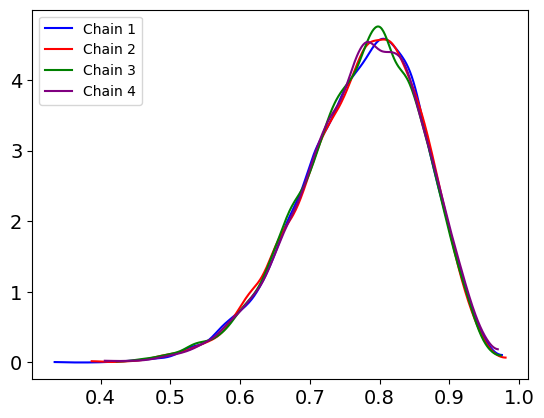

In [25]:
chain1 = idata.posterior['θ'][0, :]
chain2 = idata.posterior['θ'][1, :]
chain3 = idata.posterior['θ'][2, :]
chain4 = idata.posterior['θ'][3, :]

fig, ax = plt.subplots()
az.plot_dist(chain1, ax=ax, color="blue", label="Chain 1")
az.plot_dist(chain2, ax=ax, color="red", label="Chain 2")
az.plot_dist(chain3, ax=ax, color="green", label="Chain 3")
az.plot_dist(chain4, ax=ax, color="purple", label="Chain 4")

ax.legend()
plt.show()



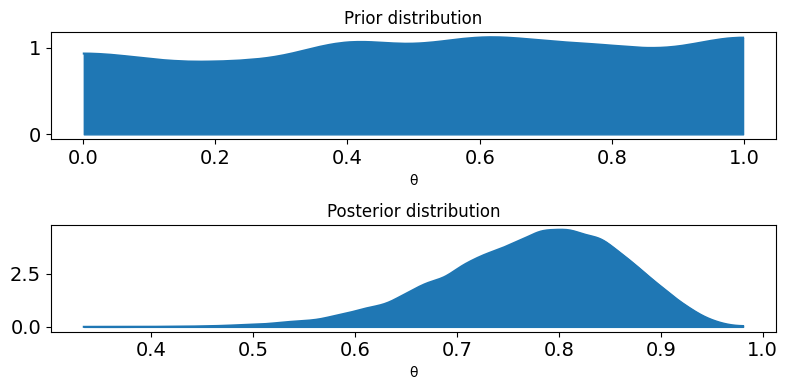

In [26]:
# Ploteamos la prior y la posterior

fig, axs = plt.subplots(2, 1, figsize=(8,4))

with model:
    prior = pm.draw(θ, 1000)

# Prior
az.plot_dist(prior, fill_kwargs={'alpha':1}, ax=axs[0])
axs[0].set_title("Prior distribution")
axs[0].set_xlabel("θ")

#Posterior
az.plot_dist(idata.posterior["θ"], fill_kwargs={'alpha':1}, ax=axs[1])
axs[1].set_title("Posterior distribution")
axs[1].set_xlabel("θ")

plt.tight_layout()
plt.show()

In [22]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.773,0.087,0.607,0.925,0.001,0.0,17341.0,23790.0,1.0


In [23]:
# Agregar las predictive distributions a idata.
with model:
    idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

idata

Sampling: [y_obs, θ]
Sampling: [y_obs]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

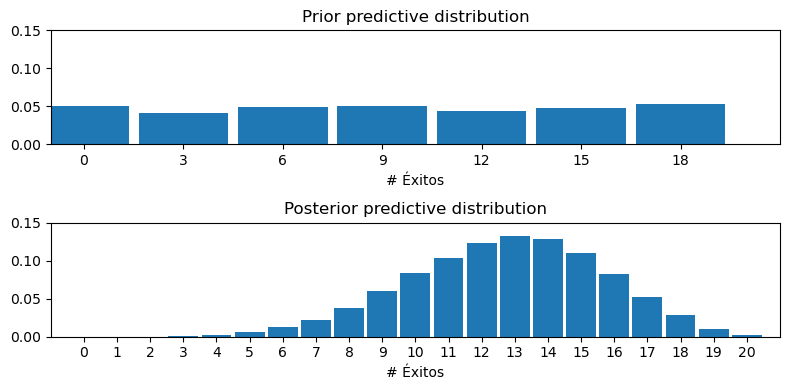

In [29]:
pred_dists = (
    idata.prior_predictive["y_obs"].values,
    idata.posterior_predictive["y_obs"].values
    )

fig, axs = plt.subplots(2, 1, figsize=(8,4))

for idx, name, dist in zip((0, 1), ("Prior", "Posterior"), pred_dists):
    az.plot_dist(dist.sum(-1), ax=axs[idx])
    axs[idx].set_title(f"{name} predictive distribution")
    axs[idx].set_xlim(-1, 21)
    axs[idx].set_ylim(0, 0.15)
    axs[idx].set_xlabel("# Éxitos")

plt.tight_layout()
plt.show()

### El modelo normal-normal con varianza conocida

Esta celda pretende ilustrar:

1. Que la estimación bayesiana es *toda la posterior*
2. Que, sin embargo, podemos hacer una estimación puntual (eg. MAP)
3. La diferencia entre la distribucion $y|\theta$ y la posterior predictiva


Para eso supongamos que tenemos el siguiente modelo (tanto la prior como la likelihood son normales):

$$
\theta \sim \mathcal{N}(\mu_{\theta}, \sigma^2=10^2)
$$
$$
X |\theta \sim \mathcal{N}(\mu=\theta, \sigma^2=1)
$$

Y los datos provienen de una distribución normal con $\mu=5$ y $\sigma^2=2^2$

In [30]:
# Generamos datos para X
X = stats.norm.rvs(loc=5, scale = 2,size = 30)

# Hacemos la inferencia bayesiana
with pm.Model() as normal_model:
    θ = pm.Normal('θ', 0, 10)
    X_obs = pm.Normal('X_obs', θ, 1, observed=X) 

    # Obtener la estimación puntual (MAP)
    map_estimate = pm.find_MAP()

    # Samplear de la posterior
    idata = pm.sample(1000, return_inferencedata=True)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [X_obs]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

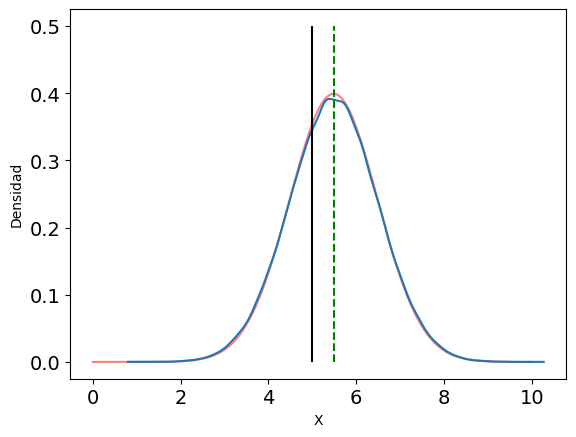

In [35]:
thetas_posterior = idata.posterior['θ'].values.flatten()

x_axis = np.linspace(0, 10, 10000)

fig, ax = plt.subplots()

# # Graficar X|theta ~ N (theta, scale=1)
# for theta in thetas_posterior[:100]: 
#     ax.plot(x_axis, stats.norm.pdf(x_axis, loc=theta, scale=1), color='k', alpha=0.05)

# Graficar X|theta para la MAP
ax.plot(x_axis, stats.norm.pdf(x_axis, loc=map_estimate['θ'], scale=1), color='red', alpha=0.5)

# Graficar la posterior predictive
az.plot_dist(idata.posterior_predictive['X_obs'].values, ax=ax)

ax.vlines(5, 0, .5, colors = 'black') # True mean
ax.vlines(map_estimate['θ'], 0, .5, linestyles='dashed', colors = 'green') # MAP estimate

ax.set_xlabel("X")
ax.set_ylabel("Densidad")

plt.show()